In [52]:
# Importação de bibliotecas
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt


In [53]:
# Leitura dos dados experimentais (15%-10FPU)
df = pd.read_csv('../BEPE FAPESP/Dados Angarita.csv', sep=',')
df = df.rename(columns=lambda x: x.strip())
# Selecionar apenas as colunas de interesse
tempo = df['Tempo [h]'].values
Glicose = df['Glicose [g/L] 15%-10FPU'].values
Xilose = df['Xilose [g/L] 15%-10FPU'].values
Celobiose = df['Celobiose [g/L] 15%-10FPU'].values
# Remover valores nan (caso existam) e alinhar todos os vetores
mask = ~np.isnan(Glicose) & ~np.isnan(Xilose) & ~np.isnan(Celobiose)
tempo = tempo[mask]
Glicose = Glicose[mask]
Xilose = Xilose[mask]
Celobiose = Celobiose[mask]


In [54]:
# MODELO CORRIGIDO - Hidrólise Enzimática com Balanço de Enzimas Correto

# Constantes do modelo
Et_total = 0.1756  # g/L - Enzimas totais (constante)

# Definição das equações do modelo

# Balanço de enzimas: Et_total = Ef + Eb_total
# Et_total é constante = 0.1756 g/L
# Eb_total calculado pela isoterma de Langmuir usando Emax
# Ef calculado algebricamente: Ef = Et_total - Eb_total

def Et_total_func():
    """Concentração total de enzimas (constante)"""
    return 0.1756  # g/L

def Eb_total(S, Emax, Kad):
    """Concentração total de enzimas ligadas (isoterma de Langmuir)"""
    return Emax * S * Kad / (1 + Kad * S) if Emax > 0 else 0

def Ef_func(S, Et_total, Emax, Kad):
    """Concentração de enzimas livres (calculada algebricamente)"""
    Eb_tot = Eb_total(S, Emax, Kad)
    return Et_total - Eb_tot

def Ebc(Eb_tot, C, S):
    """Enzimas ligadas à celulose"""
    return Eb_tot * C / S if S > 0 else 0

def Ebh(Eb_tot, H, S):
    """Enzimas ligadas à hemicelulose"""
    return Eb_tot * H / S if S > 0 else 0

def Rs(alpha, S, S0):
    """Reatividade relativa do substrato"""
    return alpha * S / S0

# Funções das taxas de reação
def r1(k1r, Ebc, S, Rs, G2, G, X, K1iG, K1iG2, K1iX):
    """Taxa de reação: Celulose → Celobiose"""
    return k1r * Ebc * S * Rs / (1 + G2 / K1iG2 + G / K1iG + X / K1iX)

def r2(k2r, Ebc, S, Rs, G2, G, X, K2iG, K2iG2, K2iX):
    """Taxa de reação: Celulose → Glicose"""
    return k2r * Ebc * S * Rs / (1 + G2 / K2iG2 + G / K2iG + X / K2iX)

def r3(k3r, Ef, G2, G, X, K3M, K3iG, K3iX):
    """Taxa de reação: Celobiose → Glicose"""
    return k3r * Ef * G2 / (((1 + G / K3iG + X / K3iX) * K3M) + G2)

def r4(k4r, Ebh, Rs, S, G2, G, X, K4iG, K4iG2, K4iX):
    """Taxa de reação: Hemicelulose → Xilose"""
    return k4r * Ebh * Rs * S / (1 + G2 / K4iG2 + G / K4iG + X / K4iX)

# Funções das derivadas (balanços de massa)
def dC_dt(r1_, r2_):
    """Taxa de consumo da celulose"""
    return -r1_ - r2_

def dG2_dt(r1_, r3_):
    """Taxa de formação/consumo da celobiose"""
    return 1.056 * r1_ - r3_

def dG_dt(r2_, r3_):
    """Taxa de formação da glicose"""
    return 1.111 * r2_ + 1.053 * r3_

def dH_dt(r4_):
    """Taxa de consumo da hemicelulose"""
    return -r4_

def dX_dt(r4_):
    """Taxa de formação da xilose"""
    return 1.136 * r4_


In [55]:
# Função para simular o sistema de EDOs com balanço correto de enzimas
def modelo(t, y, params, S0):
    """
    Modelo de hidrólise enzimática corrigido
    
    Variáveis de estado: [C, H, L, S, G2, G, X]
    Et_total constante = 0.1756 g/L
    Ef calculado algebricamente: Ef = Et_total - Eb_total
    """
    C, H, L, S, G2, G, X = y
    p = params
    
    # Concentração total de enzimas (constante)
    Et_total = Et_total_func()
    
    # Enzimas ligadas total (isoterma de Langmuir usando Emax)
    Eb_tot = Eb_total(S, p['Emax'], p['Kad'])
    
    # Enzimas livres (balanço algébrico)
    Ef = Ef_func(S, Et_total, p['Emax'], p['Kad'])
    
    # Distribuição das enzimas ligadas
    Ebc_val = Ebc(Eb_tot, C, S)
    Ebh_val = Ebh(Eb_tot, H, S)
    
    # Cálculo das taxas de reação
    Rs_val = Rs(p['alpha'], S, S0)
    
    r1_val = r1(p['k1r'], Ebc_val, S, Rs_val, G2, G, X, p['K1iG'], p['K1iG2'], p['K1iX'])
    r2_val = r2(p['k2r'], Ebc_val, S, Rs_val, G2, G, X, p['K2iG'], p['K2iG2'], p['K2iX'])
    r3_val = r3(p['k3r'], Ef, G2, G, X, p['K3M'], p['K3iG'], p['K3iX'])
    r4_val = r4(p['k4r'], Ebh_val, Rs_val, S, G2, G, X, p['K4iG'], p['K4iG2'], p['K4iX'])
    
    # Equações diferenciais
    dCdt = dC_dt(r1_val, r2_val)
    dHdt = dH_dt(r4_val)
    dLdt = 0  # Lignina inerte
    dSdt = dCdt + dHdt  # S = C + H (lignina não reage)
    dG2dt = dG2_dt(r1_val, r3_val)
    dGdt = dG_dt(r2_val, r3_val)
    dXdt = dX_dt(r4_val)
    
    return [dCdt, dHdt, dLdt, dSdt, dG2dt, dGdt, dXdt]

In [56]:
# Função de erro para ajuste dos parâmetros - Atualizada

def funcao_erro(parametros):
    """
    Função objetivo para otimização dos parâmetros
    Variáveis de estado: [C, H, L, S, G2, G, X]
    Índices: C=0, H=1, L=2, S=3, G2=4, G=5, X=6
    """
    try:
        # Condições iniciais: todas as enzimas livres em t=0
        y0_novo = [C0, H0, L0, S0, G20, G0, X0]  # [C, H, L, S, G2, G, X]
        
        # Integração numérica
        solucao = solve_ivp(lambda t, y: modelo(t, y, parametros, S0), [0, 72], y0_novo, 
                           t_eval=tempo, method='RK45', rtol=1e-8)
        
        if not solucao.success:
            return 1e6
        
        # Extrair as soluções - novos índices
        C_sol = solucao.y[0]  # Celulose
        H_sol = solucao.y[1]  # Hemicelulose  
        G2_sol = solucao.y[4] # Celobiose
        G_sol = solucao.y[5]  # Glicose
        X_sol = solucao.y[6]  # Xilose
        
        # Cálculo do erro quadrático médio apenas para pontos válidos
        erro_glicose = np.sum((G_sol[mask] - Glicose[mask])**2)
        erro_xilose = np.sum((X_sol[mask] - Xilose[mask])**2)
        erro_celobiose = np.sum((G2_sol[mask] - Celobiose[mask])**2)
        
        erro_total = erro_glicose + erro_xilose + erro_celobiose
        
        return erro_total
        
    except Exception as e:
        print(f"Erro na simulação: {e}")
        return 1e6


In [57]:
# Valores iniciais e ajuste dos parâmetros
# Vamos otimizar apenas alguns parâmetros principais
param_names = ['k1r', 'k2r']  # Começar com parâmetros de hidrólise da celulose
param_init = [0.177, 8.81]

# Condições iniciais
biomass_composition = {'cellulose': 0.66, 'hemicellulose': 0.083, 'lignin': 0.257}
solids_loading_g_L = 150  # g/L
C0 = solids_loading_g_L * biomass_composition['cellulose']
H0 = solids_loading_g_L * biomass_composition['hemicellulose']
L0 = solids_loading_g_L * biomass_composition['lignin']
S0 = C0 + H0 + L0

# Condições iniciais dos produtos
G20 = 0  # Celobiose inicial
G0 = 0   # Glicose inicial
X0 = 0   # Xilose inicial

# Vetor de condições iniciais: [C, H, L, S, G2, G, X]
y0 = [C0, H0, L0, S0, G20, G0, X0]

print(f"Condições iniciais:")
print(f"Celulose (C0): {C0:.2f} g/L")
print(f"Hemicelulose (H0): {H0:.2f} g/L") 
print(f"Lignina (L0): {L0:.2f} g/L")
print(f"Substrato total (S0): {S0:.2f} g/L")
print(f"Celobiose (G20): {G20} g/L")
print(f"Glicose (G0): {G0} g/L")
print(f"Xilose (X0): {X0} g/L")
print(f"Et_total: {Et_total_func()} g/L")
print(f"Variáveis de estado: {len(y0)} ([C, H, L, S, G2, G, X]")

# Condições iniciais do modelo corrigido
print("Configurando condições iniciais...")

# Composição da biomassa
biomass_composition = {'cellulose': 0.66, 'hemicellulose': 0.083, 'lignin': 0.257}
solids_loading_g_L = 150  # g/L

# Cálculo das condições iniciais
C0 = solids_loading_g_L * biomass_composition['cellulose']      # g/L
H0 = solids_loading_g_L * biomass_composition['hemicellulose']  # g/L  
L0 = solids_loading_g_L * biomass_composition['lignin']         # g/L
S0 = C0 + H0  # Substrato total = celulose + hemicelulose (lignina não reage)
G20 = 0       # Celobiose inicial
G0 = 0        # Glicose inicial
X0 = 0        # Xilose inicial

# Lista de condições iniciais: [C, H, L, S, G2, G, X]
y0 = [C0, H0, L0, S0, G20, G0, X0]

print(f"Condições iniciais configuradas:")
print(f"  Celulose (C0): {C0:.2f} g/L")
print(f"  Hemicelulose (H0): {H0:.2f} g/L") 
print(f"  Lignina (L0): {L0:.2f} g/L")
print(f"  Substrato total (S0): {S0:.2f} g/L")
print(f"  Celobiose (G20): {G20} g/L")
print(f"  Glicose (G0): {G0} g/L")
print(f"  Xilose (X0): {X0} g/L")
print(f"  Et_total: {Et_total_func()} g/L")
print(f"  Variáveis de estado: {len(y0)} ([C, H, L, S, G2, G, X])")

# Parâmetros de teste (sem otimização por enquanto)
params_basicos = {
    'alpha': 1,
    'Emax': 8.32/1000,  # Valor correto de Emax
    'Kad': 7.16,
    'k1r': 0.177,
    'k2r': 8.81,
    'k3r': 201.0,
    'k4r': 16.34,
    'K1iG2': 0.402,
    'K1iG': 2.71,
    'K1iX': 2.15,
    'K2iG2': 119.6,
    'K2iG': 4.69,
    'K2iX': 0.095,
    'K3M': 26.6,
    'K3iG': 11.06,
    'K3iX': 1.023,
    'K4iG2': 16.25,
    'K4iG': 4.0,
    'K4iX': 154.0
}

print("\nParâmetros básicos configurados para teste inicial.")
print("Execute a próxima célula para testar o modelo.")


Condições iniciais:
Celulose (C0): 99.00 g/L
Hemicelulose (H0): 12.45 g/L
Lignina (L0): 38.55 g/L
Substrato total (S0): 150.00 g/L
Celobiose (G20): 0 g/L
Glicose (G0): 0 g/L
Xilose (X0): 0 g/L
Et_total: 0.1756 g/L
Variáveis de estado: 7 ([C, H, L, S, G2, G, X]
Configurando condições iniciais...
Condições iniciais configuradas:
  Celulose (C0): 99.00 g/L
  Hemicelulose (H0): 12.45 g/L
  Lignina (L0): 38.55 g/L
  Substrato total (S0): 111.45 g/L
  Celobiose (G20): 0 g/L
  Glicose (G0): 0 g/L
  Xilose (X0): 0 g/L
  Et_total: 0.1756 g/L
  Variáveis de estado: 7 ([C, H, L, S, G2, G, X])

Parâmetros básicos configurados para teste inicial.
Execute a próxima célula para testar o modelo.


In [58]:
# Teste do modelo corrigido
print("Testando modelo corrigido...")

# Parâmetros de teste
params_teste = {
    'alpha': 1,
    'Emax': 8.32/1000,  # Valor correto de Emax
    'Kad': 7.16,
    'k1r': 0.177,
    'k2r': 8.81,
    'k3r': 201.0,
    'k4r': 16.34,
    'K1iG2': 0.402,
    'K1iG': 2.71,
    'K1iX': 2.15,
    'K2iG2': 119.6,
    'K2iG': 4.69,
    'K2iX': 0.095,
    'K3M': 26.6,
    'K3iG': 11.06,
    'K3iX': 1.023,
    'K4iG2': 16.25,
    'K4iG': 4.0,
    'K4iX': 154.0
}

try:
    # Verificar intervalo de tempo dos dados experimentais
    print(f"Tempo experimental: {tempo[0]:.1f} a {tempo[-1]:.1f} h")
    
    # Teste de simulação
    sol_teste = solve_ivp(lambda t, y: modelo(t, y, params_teste, S0), 
                         [tempo[0], tempo[-1]], 
                         y0, 
                         t_eval=tempo, 
                         method='LSODA', 
                         max_step=0.5)
    
    if sol_teste.success:
        print("✓ Modelo funcionando corretamente!")
        print(f"  - Pontos simulados: {len(sol_teste.t)}")
        print(f"  - Variáveis de estado: {sol_teste.y.shape[0]} ([C, H, L, S, G2, G, X])")
        
        # Verificar balanço de enzimas
        Et_total_val = Et_total_func()
        S_final = sol_teste.y[3, -1]  # S no tempo final
        Eb_tot_final = Eb_total(S_final, params_teste['Emax'], params_teste['Kad'])
        Ef_final = Ef_func(S_final, Et_total_val, params_teste['Emax'], params_teste['Kad'])
        
        print(f"  - Et_total: {Et_total_val:.4f} g/L")
        print(f"  - Eb_total (final): {Eb_tot_final:.4f} g/L")
        print(f"  - Ef (final): {Ef_final:.4f} g/L")
        print(f"  - Balanço: Et = Ef + Eb = {Ef_final + Eb_tot_final:.4f} g/L")
        
        # Concentrações finais dos produtos
        G_final = sol_teste.y[5, -1]   # Glicose
        X_final = sol_teste.y[6, -1]   # Xilose
        G2_final = sol_teste.y[4, -1]  # Celobiose
        
        print(f"  - Glicose final: {G_final:.2f} g/L")
        print(f"  - Xilose final: {X_final:.2f} g/L")
        print(f"  - Celobiose final: {G2_final:.2f} g/L")
    else:
        print("✗ Erro na simulação:", sol_teste.message)
        
except Exception as e:
    print(f"✗ Erro no teste: {e}")

Testando modelo corrigido...
Tempo experimental: 0.0 a 96.0 h
✓ Modelo funcionando corretamente!
  - Pontos simulados: 11
  - Variáveis de estado: 7 ([C, H, L, S, G2, G, X])
  - Et_total: 0.1756 g/L
  - Eb_total (final): 0.0083 g/L
  - Ef (final): 0.1673 g/L
  - Balanço: Et = Ef + Eb = 0.1756 g/L
  - Glicose final: 8.28 g/L
  - Xilose final: 14.03 g/L
  - Celobiose final: 0.13 g/L


In [59]:
# Diagnóstico dos tamanhos dos vetores antes do ajuste
print('Tamanho tempo:', len(tempo))
print('Tamanho Glicose:', len(Glicose))
print('Tamanho Xilose:', len(Xilose))
print('Tamanho Celobiose:', len(Celobiose))

# Conferir se todos têm o mesmo tamanho
tam_min = min(len(tempo), len(Glicose), len(Xilose), len(Celobiose))
if not (len(tempo) == len(Glicose) == len(Xilose) == len(Celobiose)):
    print('Atenção: tamanhos diferentes detectados! Ajustando para o menor tamanho.')
    tempo = tempo[:tam_min]
    Glicose = Glicose[:tam_min]
    Xilose = Xilose[:tam_min]
    Celobiose = Celobiose[:tam_min]
    print('Novos tamanhos:', len(tempo), len(Glicose), len(Xilose), len(Celobiose))
else:
    print('Todos os vetores estão alinhados.')

Tamanho tempo: 11
Tamanho Glicose: 11
Tamanho Xilose: 11
Tamanho Celobiose: 11
Todos os vetores estão alinhados.


In [60]:
# AJUSTE RÁPIDO DE PARÂMETROS - Modelo Corrigido

# Criar máscara para pontos válidos
mask = ~np.isnan(Glicose) & ~np.isnan(Xilose) & ~np.isnan(Celobiose)

def func_ajuste_rapido(params_vetor, param_names, tempo, Glicose, Xilose, Celobiose, y0, S0):
    """
    Função objetivo simplificada para ajuste rápido de parâmetros
    """
    try:
        # Montar dicionário de parâmetros
        params = {
            'alpha': 1,
            'Emax': 8.32/1000,  # Valor correto de Emax
            'Kad': 7.16,
            'k1r': 0.177,
            'k2r': 8.81,
            'k3r': 201.0,
            'k4r': 16.34,
            'K1iG2': 0.402,
            'K1iG': 2.71,
            'K1iX': 2.15,
            'K2iG2': 119.6,
            'K2iG': 4.69,
            'K2iX': 0.095,
            'K3M': 26.6,
            'K3iG': 11.06,
            'K3iX': 1.023,
            'K4iG2': 16.25,
            'K4iG': 4.0,
            'K4iX': 154.0
        }
        
        # Atualizar com parâmetros otimizados
        for i, name in enumerate(param_names):
            params[name] = params_vetor[i]
        
        # Integração numérica
        sol = solve_ivp(lambda t, y: modelo(t, y, params, S0), 
                       [tempo[0], tempo[-1]], 
                       y0, 
                       t_eval=tempo, 
                       method='LSODA', 
                       max_step=0.5)
        
        if not sol.success:
            return np.full(len(tempo[mask]) * 3, 1e6)
        
        # Extrair soluções: [C, H, L, S, G2, G, X]
        G_sim = sol.y[5][mask]   # Glicose
        X_sim = sol.y[6][mask]   # Xilose
        G2_sim = sol.y[4][mask]  # Celobiose
        
        # Calcular resíduos
        residuos = np.concatenate([
            G_sim - Glicose[mask],
            X_sim - Xilose[mask], 
            G2_sim - Celobiose[mask]
        ])
        
        return residuos
        
    except Exception as e:
        print(f"Erro na simulação: {e}")
        return np.full(len(tempo[mask]) * 3, 1e6)

# Ajuste usando poucos parâmetros para teste rápido
param_names_rapido = ['k1r', 'k2r', 'k3r']
param_init_rapido = [0.177, 8.81, 201.0]

print("Iniciando ajuste rápido dos parâmetros...")
print(f"Parâmetros a otimizar: {param_names_rapido}")
print(f"Valores iniciais: {param_init_rapido}")

# Executar otimização
res_rapido = least_squares(
    func_ajuste_rapido, 
    param_init_rapido, 
    args=(param_names_rapido, tempo, Glicose, Xilose, Celobiose, y0, S0),
    bounds=([0.01, 0.01, 1.0], [10.0, 50.0, 1000.0]),
    max_nfev=100  # Limitar iterações para teste rápido
)

if res_rapido.success:
    print("✓ Ajuste rápido concluído com sucesso!")
    
    # Criar dicionário de parâmetros otimizados
    param_otimos = {
        'alpha': 1,
        'Emax': 8.32/1000,
        'Kad': 7.16,
        'k1r': 0.177,
        'k2r': 8.81,
        'k3r': 201.0,
        'k4r': 16.34,
        'K1iG2': 0.402,
        'K1iG': 2.71,
        'K1iX': 2.15,
        'K2iG2': 119.6,
        'K2iG': 4.69,
        'K2iX': 0.095,
        'K3M': 26.6,
        'K3iG': 11.06,
        'K3iX': 1.023,
        'K4iG2': 16.25,
        'K4iG': 4.0,
        'K4iX': 154.0
    }
    
    # Atualizar com valores otimizados
    for i, name in enumerate(param_names_rapido):
        param_otimos[name] = res_rapido.x[i]
    
    print("Parâmetros otimizados:")
    for name in param_names_rapido:
        print(f"  {name}: {param_otimos[name]:.4f}")
    
    print(f"Erro final: {np.sum(res_rapido.fun**2):.2f}")
    
else:
    print("✗ Falha no ajuste:", res_rapido.message)
    param_otimos = None

Iniciando ajuste rápido dos parâmetros...
Parâmetros a otimizar: ['k1r', 'k2r', 'k3r']
Valores iniciais: [0.177, 8.81, 201.0]
✓ Ajuste rápido concluído com sucesso!
Parâmetros otimizados:
  k1r: 10.0000
  k2r: 50.0000
  k3r: 1000.0000
Erro final: 331.44


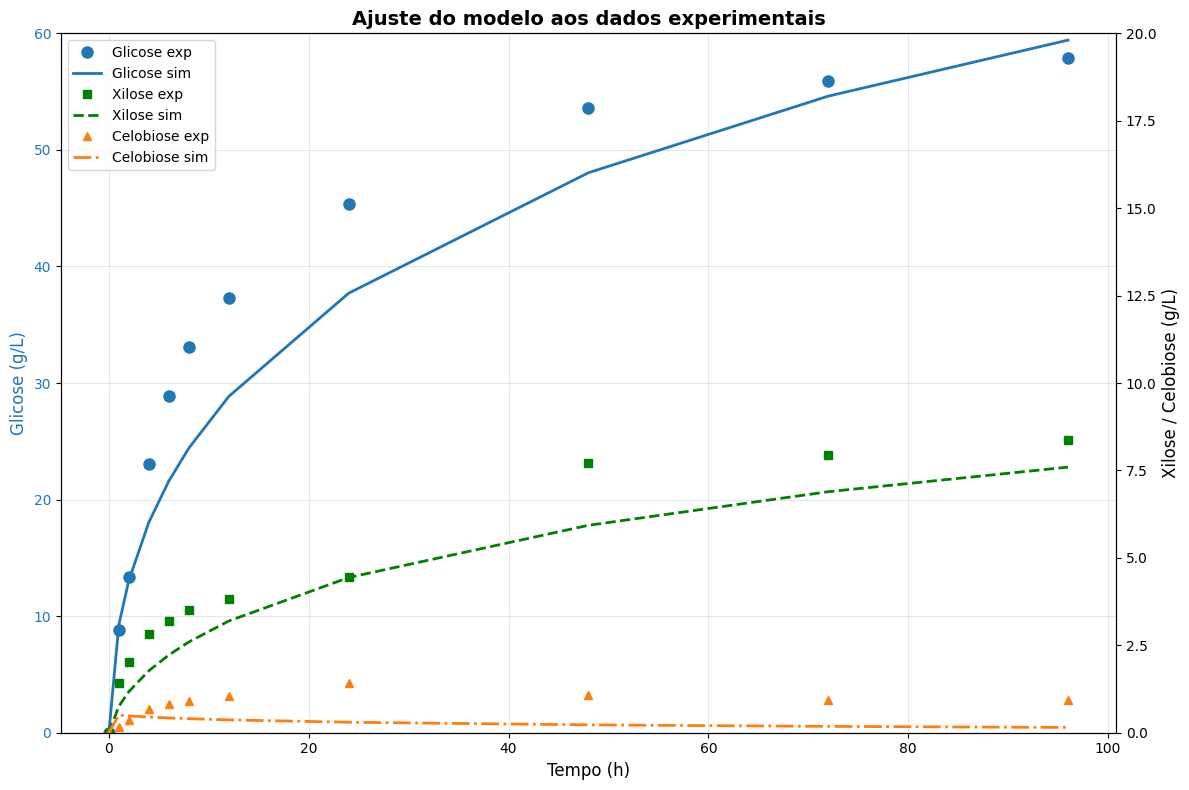


MODELO CORRIGIDO - RESULTADOS
Enzimas totais (Et): 0.1756 g/L (constante)
Parâmetros otimizados:
  k1r: 10.0000
  k2r: 50.0000
  k3r: 1000.0000

Erro quadrático total: 331.44

BALANÇO DE ENZIMAS:
t=0: Ef = 0.1673, Eb = 0.0083, Et = 0.1756
t=final: Ef = 0.1673, Eb = 0.0083, Et = 0.1756


In [61]:
# Simulação com parâmetros ajustados e comparação com dados experimentais
if 'param_otimos' in locals() and param_otimos is not None:
    sol = solve_ivp(lambda t, y: modelo(t, y, param_otimos, S0), [tempo[0], tempo[-1]], y0, t_eval=tempo, method='LSODA', max_step=0.5)
    G_sim = sol.y[5]   # Glicose
    X_sim = sol.y[6]   # Xilose
    G2_sim = sol.y[4]  # Celobiose

    fig, ax1 = plt.subplots(figsize=(12,8))

    # Glicose - eixo y da esquerda (0-60 g/L)
    ax1.plot(tempo, Glicose, 'o', label='Glicose exp', color='tab:blue', markersize=8)
    ax1.plot(tempo, G_sim, '-', label='Glicose sim', color='tab:blue', linewidth=2)
    ax1.set_xlabel('Tempo (h)', fontsize=12)
    ax1.set_ylabel('Glicose (g/L)', color='tab:blue', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(0, 60)  # Escala fixa 0-60 como na imagem
    ax1.grid(True, alpha=0.3)

    # Xilose e Celobiose - eixo y da direita (0-20 g/L)
    ax2 = ax1.twinx()
    ax2.plot(tempo, Xilose, 's', label='Xilose exp', color='green', markersize=6)
    ax2.plot(tempo, X_sim, '--', label='Xilose sim', color='green', linewidth=2)
    ax2.plot(tempo, Celobiose, '^', label='Celobiose exp', color='tab:orange', markersize=6)
    ax2.plot(tempo, G2_sim, '-.', label='Celobiose sim', color='tab:orange', linewidth=2)
    ax2.set_ylabel('Xilose / Celobiose (g/L)', color='black', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_ylim(0, 20)  # Escala fixa 0-20 como na imagem

    # Legendas combinadas
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

    plt.title('Ajuste do modelo aos dados experimentais', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Mostrar informações do modelo
    print("\n" + "="*50)
    print("MODELO CORRIGIDO - RESULTADOS")
    print("="*50)
    Et_total_val = Et_total_func()
    print(f"Enzimas totais (Et): {Et_total_val:.4f} g/L (constante)")
    print(f"Parâmetros otimizados:")
    for name in param_names_rapido:
        print(f"  {name}: {param_otimos[name]:.4f}")
    
    # Calcular erro final
    residuos_final = func_ajuste_rapido(res_rapido.x, param_names_rapido, tempo, Glicose, Xilose, Celobiose, y0, S0)
    print(f"\nErro quadrático total: {np.sum(residuos_final**2):.2f}")
    
    # Calcular balanço de enzimas em t=0 e t=final
    S_inicial = S0
    S_final = sol.y[3][-1]  # S no tempo final
    
    Eb_inicial = Eb_total(S_inicial, param_otimos['Emax'], param_otimos['Kad'])
    Ef_inicial = Ef_func(S_inicial, Et_total_val, param_otimos['Emax'], param_otimos['Kad'])
    
    Eb_final = Eb_total(S_final, param_otimos['Emax'], param_otimos['Kad'])
    Ef_final = Ef_func(S_final, Et_total_val, param_otimos['Emax'], param_otimos['Kad'])
    
    print(f"\nBALANÇO DE ENZIMAS:")
    print(f"t=0: Ef = {Ef_inicial:.4f}, Eb = {Eb_inicial:.4f}, Et = {Ef_inicial + Eb_inicial:.4f}")
    print(f"t=final: Ef = {Ef_final:.4f}, Eb = {Eb_final:.4f}, Et = {Ef_final + Eb_final:.4f}")
    
else:
    print("Parâmetros não foram otimizados ainda. Execute a célula de ajuste rápido primeiro.")

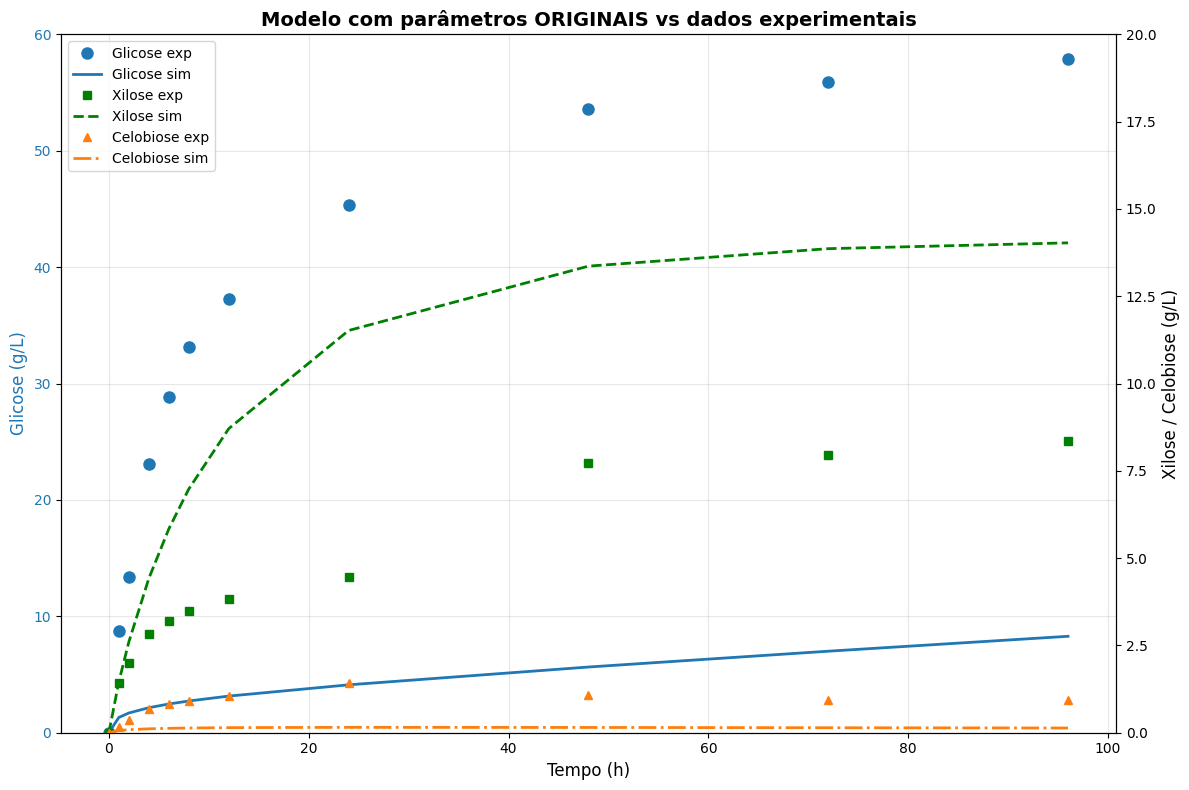


MODELO COM PARÂMETROS ORIGINAIS
Enzimas totais (Et): 0.1756 g/L (constante)
Parâmetros originais (não otimizados):
  k1r: 0.1770
  k2r: 8.8100
  k3r: 201.0000

BALANÇO DE ENZIMAS (PARÂMETROS ORIGINAIS):
t=0: Ef = 0.1673, Eb = 0.0083, Et = 0.1756
t=final: Ef = 0.1673, Eb = 0.0083, Et = 0.1756

CONCENTRAÇÕES FINAIS (PARÂMETROS ORIGINAIS):
  Glicose final: 8.28 g/L
  Xilose final: 14.03 g/L
  Celobiose final: 0.13 g/L


In [62]:
# Simulação com parâmetros ORIGINAIS e comparação com dados experimentais
# Usando os parâmetros básicos originais sem otimização

# Parâmetros originais (não otimizados)
params_basicos = {
    'alpha': 1,
    'Emax': 8.32/1000,  # Valor correto de Emax
    'Kad': 7.16,
    'k1r': 0.177,
    'k2r': 8.81,
    'k3r': 201.0,
    'k4r': 16.34,
    'K1iG2': 0.402,
    'K1iG': 2.71,
    'K1iX': 2.15,
    'K2iG2': 119.6,
    'K2iG': 4.69,
    'K2iX': 0.095,
    'K3M': 26.6,
    'K3iG': 11.06,
    'K3iX': 1.023,
    'K4iG2': 16.25,
    'K4iG': 4.0,
    'K4iX': 154.0
}

# Simular com parâmetros originais
sol_orig = solve_ivp(lambda t, y: modelo(t, y, params_basicos, S0), [tempo[0], tempo[-1]], y0, t_eval=tempo, method='LSODA', max_step=0.5)
G_sim_orig = sol_orig.y[5]   # Glicose
X_sim_orig = sol_orig.y[6]   # Xilose
G2_sim_orig = sol_orig.y[4]  # Celobiose

fig, ax1 = plt.subplots(figsize=(12,8))

# Glicose - eixo y da esquerda (0-60 g/L)
ax1.plot(tempo, Glicose, 'o', label='Glicose exp', color='tab:blue', markersize=8)
ax1.plot(tempo, G_sim_orig, '-', label='Glicose sim', color='tab:blue', linewidth=2)
ax1.set_xlabel('Tempo (h)', fontsize=12)
ax1.set_ylabel('Glicose (g/L)', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 60)  # Escala fixa 0-60 como na imagem
ax1.grid(True, alpha=0.3)

# Xilose e Celobiose - eixo y da direita (0-20 g/L)
ax2 = ax1.twinx()
ax2.plot(tempo, Xilose, 's', label='Xilose exp', color='green', markersize=6)
ax2.plot(tempo, X_sim_orig, '--', label='Xilose sim', color='green', linewidth=2)
ax2.plot(tempo, Celobiose, '^', label='Celobiose exp', color='tab:orange', markersize=6)
ax2.plot(tempo, G2_sim_orig, '-.', label='Celobiose sim', color='tab:orange', linewidth=2)
ax2.set_ylabel('Xilose / Celobiose (g/L)', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, 20)  # Escala fixa 0-20 como na imagem

# Legendas combinadas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.title('Modelo com parâmetros ORIGINAIS vs dados experimentais', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Mostrar informações do modelo com parâmetros originais
print("\n" + "="*50)
print("MODELO COM PARÂMETROS ORIGINAIS")
print("="*50)
Et_total_val = Et_total_func()
print(f"Enzimas totais (Et): {Et_total_val:.4f} g/L (constante)")
print(f"Parâmetros originais (não otimizados):")
print(f"  k1r: {params_basicos['k1r']:.4f}")
print(f"  k2r: {params_basicos['k2r']:.4f}")
print(f"  k3r: {params_basicos['k3r']:.4f}")

# Calcular balanço de enzimas em t=0 e t=final
S_inicial = S0
S_final_orig = sol_orig.y[3][-1]  # S no tempo final

Eb_inicial_orig = Eb_total(S_inicial, params_basicos['Emax'], params_basicos['Kad'])
Ef_inicial_orig = Ef_func(S_inicial, Et_total_val, params_basicos['Emax'], params_basicos['Kad'])

Eb_final_orig = Eb_total(S_final_orig, params_basicos['Emax'], params_basicos['Kad'])
Ef_final_orig = Ef_func(S_final_orig, Et_total_val, params_basicos['Emax'], params_basicos['Kad'])

print(f"\nBALANÇO DE ENZIMAS (PARÂMETROS ORIGINAIS):")
print(f"t=0: Ef = {Ef_inicial_orig:.4f}, Eb = {Eb_inicial_orig:.4f}, Et = {Ef_inicial_orig + Eb_inicial_orig:.4f}")
print(f"t=final: Ef = {Ef_final_orig:.4f}, Eb = {Eb_final_orig:.4f}, Et = {Ef_final_orig + Eb_final_orig:.4f}")

# Concentrações finais dos produtos
G_final_orig = sol_orig.y[5, -1]   # Glicose
X_final_orig = sol_orig.y[6, -1]   # Xilose
G2_final_orig = sol_orig.y[4, -1]  # Celobiose

print(f"\nCONCENTRAÇÕES FINAIS (PARÂMETROS ORIGINAIS):")
print(f"  Glicose final: {G_final_orig:.2f} g/L")
print(f"  Xilose final: {X_final_orig:.2f} g/L")
print(f"  Celobiose final: {G2_final_orig:.2f} g/L")

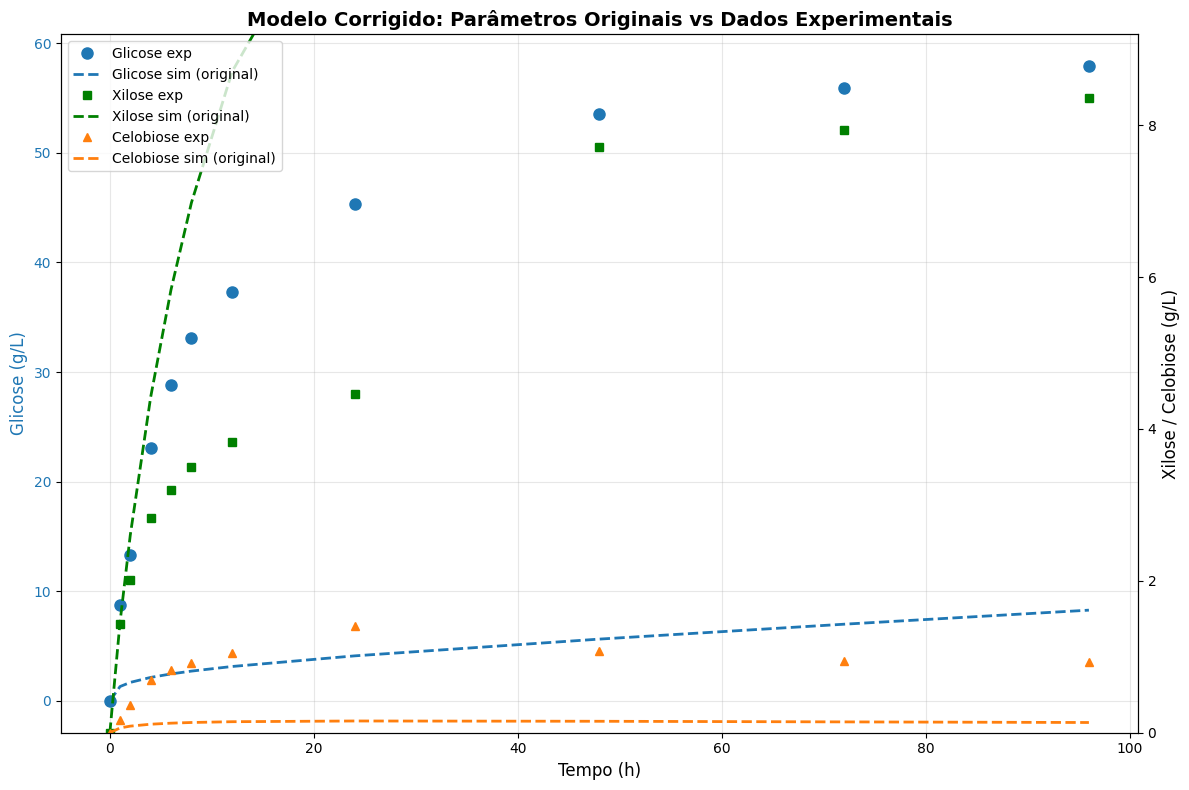

PARÂMETROS ORIGINAIS - BALANÇO DE ENZIMAS:
t=final: Ef = 0.1673, Eb = 0.0083, Et = 0.1756
Conservação: True


In [63]:
# SIMULAÇÃO COM PARÂMETROS ORIGINAIS - Modelo Corrigido

# Parâmetros originais (com Emax correto)
param_originais = {
    'alpha': 1,
    'Emax': 8.32/1000,  # Valor correto de Emax
    'Kad': 7.16,
    'k1r': 0.177,
    'k2r': 8.81,
    'k3r': 201.0,
    'k4r': 16.34,
    'K1iG2': 0.402,
    'K1iG': 2.71,
    'K1iX': 2.15,
    'K2iG2': 119.6,
    'K2iG': 4.69,
    'K2iX': 0.095,
    'K3M': 26.6,
    'K3iG': 11.06,
    'K3iX': 1.023,
    'K4iG2': 16.25,
    'K4iG': 4.0,
    'K4iX': 154.0
}

# Simular com parâmetros originais
sol_originais = solve_ivp(lambda t, y: modelo(t, y, param_originais, S0), 
                          [tempo[0], tempo[-1]], 
                          y0, 
                          t_eval=tempo, 
                          method='LSODA', 
                          max_step=0.5)

# Extrair resultados: [C, H, L, S, G2, G, X]
G_sim_orig = sol_originais.y[5]   # Glicose
X_sim_orig = sol_originais.y[6]   # Xilose
G2_sim_orig = sol_originais.y[4]  # Celobiose

fig, ax1 = plt.subplots(figsize=(12,8))

# Glicose - eixo y da esquerda
ax1.plot(tempo, Glicose, 'o', label='Glicose exp', color='tab:blue', markersize=8)
ax1.plot(tempo, G_sim_orig, '--', label='Glicose sim (original)', color='tab:blue', linewidth=2)
ax1.set_xlabel('Tempo (h)', fontsize=12)
ax1.set_ylabel('Glicose (g/L)', color='tab:blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, alpha=0.3)

# Xilose e Celobiose - eixo y da direita
ax2 = ax1.twinx()
ax2.plot(tempo, Xilose, 's', label='Xilose exp', color='green', markersize=6)
ax2.plot(tempo, X_sim_orig, '--', label='Xilose sim (original)', color='green', linewidth=2)
ax2.plot(tempo, Celobiose, '^', label='Celobiose exp', color='tab:orange', markersize=6)
ax2.plot(tempo, G2_sim_orig, '--', label='Celobiose sim (original)', color='tab:orange', linewidth=2)
ax2.set_ylabel('Xilose / Celobiose (g/L)', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0, max(max(Xilose), max(Celobiose)) * 1.1)

# Legendas combinadas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.title('Modelo Corrigido: Parâmetros Originais vs Dados Experimentais', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Verificar balanço de enzimas com parâmetros originais
Et_total_val = Et_total_func()
S_final_orig = sol_originais.y[3][-1]
Eb_final_orig = Eb_total(S_final_orig, param_originais['Emax'], param_originais['Kad'])
Ef_final_orig = Ef_func(S_final_orig, Et_total_val, param_originais['Emax'], param_originais['Kad'])

print("PARÂMETROS ORIGINAIS - BALANÇO DE ENZIMAS:")
print(f"t=final: Ef = {Ef_final_orig:.4f}, Eb = {Eb_final_orig:.4f}, Et = {Ef_final_orig + Eb_final_orig:.4f}")
print(f"Conservação: {abs((Ef_final_orig + Eb_final_orig) - Et_total_val) < 1e-6}")

In [64]:
# Gerar 300 pontos igualmente espaçados no intervalo de tempo experimental e criar DataFrame
if 'param_otimos' in locals() and param_otimos is not None:
    try:
        tempo_modelo_300 = np.linspace(tempo[0], tempo[-1], 300)
        sol_modelo_300 = solve_ivp(lambda t, y: modelo(t, y, param_otimos, S0), 
                                   [tempo_modelo_300[0], tempo_modelo_300[-1]], 
                                   y0, 
                                   t_eval=tempo_modelo_300, 
                                   method='LSODA', 
                                   max_step=0.5)
        
        # Índices corretos: [C, H, L, S, G2, G, X]
        G_sim_300 = sol_modelo_300.y[5]   # Glicose
        X_sim_300 = sol_modelo_300.y[6]   # Xilose  
        G2_sim_300 = sol_modelo_300.y[4]  # Celobiose
        
        df_modelo_300 = pd.DataFrame({
            'Tempo (h)': tempo_modelo_300,
            'Glicose (g/L)': G_sim_300,
            'Xilose (g/L)': X_sim_300,
            'Celobiose (g/L)': G2_sim_300
        })
        
        print("DataFrame com 300 pontos criado com sucesso!")
        print(f"Primeiras 5 linhas:")
        display(df_modelo_300.head())
        
        print(f"\nÚltimas 5 linhas:")
        display(df_modelo_300.tail())
        
    except Exception as e:
        print('Erro ao gerar os pontos do modelo:', e)
else:
    print("Parâmetros não foram otimizados ainda. Execute a célula de ajuste rápido primeiro.")

DataFrame com 300 pontos criado com sucesso!
Primeiras 5 linhas:


,Tempo (h),Glicose (g/L),Xilose (g/L),Celobiose (g/L)
0,0.000000,0.000000,0.000000,0.000000
1,0.321070,4.986911,0.345040,0.470746
2,0.642140,7.339480,0.562809,0.502733
3,0.963211,9.086085,0.738569,0.502940
4,1.284281,10.517127,0.890131,0.497337



Últimas 5 linhas:


,Tempo (h),Glicose (g/L),Xilose (g/L),Celobiose (g/L)
295,94.715719,59.191256,7.561858,0.152888
296,95.036789,59.248181,7.570175,0.152551
297,95.357860,59.304922,7.578465,0.152216
298,95.678930,59.361478,7.586727,0.151882
299,96.000000,59.417852,7.594962,0.151550


In [65]:
# # Parâmetros que mais funcionam no ajuste

#     params['alpha'] = 1  # fixo
#     params['k4r'] = 16.34  # fixo 
#     # params['K4iG'] = 4.0  # fixo
#     params['K4iG2'] = 16.25  # fixo
#     # params['K4iX'] = 154.0  # fixo
#     # params['k3r'] = 201.0  # fixo
#     # params['K3M'] = 26.6  # fixo
#     # params['K3iG'] = 11.06  # fixo
#     # params['K3iX'] = 1.023  # fixo
#     # params['k2r'] = 8.81  # fixo
#     # params['K2iG'] = 2.71  # fixo
#     # params['K2iG2'] = 0.402  # fixo
#     # params['K2iX'] = 2.15  # fixo
#     # params['k1r'] = 0.177  # fixo
#     # params['K1iG'] = 7.16  # fixo
#     # params['K1iG2'] = 8.32  # fixo
#     # params['K1iX'] = 0.095  # fixo
#     params['Emax'] = 8.32  # fixo
#     params['Kad'] = 7.16  # fixo